In [10]:
# Import libraries
%matplotlib notebook
import os, sys, warnings
import numpy as np
from scipy import stats
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.widgets import Button
import matplotlib.lines as mlines
import warnings

In [11]:
# Create a function to import the nc files
def LoadNC(filename,  path = '../Data/'):
    '''
    
    '''
    
    X = {}
    DateFormat = '%Y-%m-%d %H:%M:%S' 
    
    with Dataset(path + filename, 'r') as nc:
        # Load the grid
        lat = nc.variables['lat'][:,:]
        lon = nc.variables['lon'][:,:]

        X['lat'] = lat
        X['lon'] = lon
        
        # Collect the time information
        time = nc.variables['date'][:]
        dates = np.asarray([datetime.strptime(time[d], DateFormat) for d in range(len(time))])
        
        X['date'] = dates
        X['year']  = np.asarray([d.year for d in dates])
        X['month'] = np.asarray([d.month for d in dates])
        X['day']   = np.asarray([d.day for d in dates])
        X['ymd']   = np.asarray([datetime(d.year, d.month, d.day) for d in dates])
        
        # Load the mask data if present
        SName = list(set(nc.variables.keys()).difference(['lat', 'lon', 'date', 'mask']))[0]
        if 'mask' in nc.variables.keys():
            X['mask'] = nc.variables['mask'][:,:]
        # Collect the data itself
        X[str(SName)] = nc.variables[str(SName)][:,:,:]
    return X

In [12]:
# A function to subset the data
def SubsetData(X, Lat, Lon, LatMin, LatMax, LonMin, LonMax):
    '''
    
    '''
    
    # Collect the original sizes of the data/lat/lon
    I, J, T = X.shape
    
    # Reshape the data into a 2D array and lat/lon to a 1D array for easier referencing.
    X2D   = X.reshape(I*J, T, order = 'F')
    Lat1D = Lat.reshape(I*J, order = 'F')
    Lon1D = Lon.reshape(I*J, order = 'F')
    
    # Find the indices in which to make the subset.
    LatInd = np.where( (Lat1D >= LatMin) & (Lat1D <= LatMax) )[0]
    LonInd = np.where( (Lon1D >= LonMin) & (Lon1D <= LonMax) )[0]
    
    # Find the points where the lat and lon subset overlap. This comprises the subsetted grid.
    SubInd = np.intersect1d(LatInd, LonInd)
    
    # Next find, the I and J dimensions of subsetted grid.
    Start = 0 # The starting point of the column counting.
    Count = 1 # Row count starts at 1
    Isub  = 0 # Start by assuming subsetted column size is 0.
    
    for n in range(len(SubInd[:-1])): # Exclude the last value to prevent indexing errors.
        IndDiff = SubInd[n+1] - SubInd[n] # Obtain difference between this index and the next.
        if (n+2) == len(SubInd): # At the last value, everything needs to be increased by 2 to account for the missing indice at the end.
            Isub = np.nanmax([Isub, n+2 - Start]) # Note since this is the last indice, and this row is counted, there is no Count += 1.
        elif ( (IndDiff > 1) |              # If the difference is greater than 1, or if
             (np.mod(SubInd[n]+1,I) == 0) ):# SubInd is divisible by I, then a new row 
                                            # is started in the gridded array.
            Isub = np.nanmax([Isub, n+1 - Start]) # Determine the highest column count (may not be the same from row to row)
            Start = n+1 # Start the counting anew.
            Count = Count + 1 # Increment the row count by 1 as the next row is entered.
        else:
            pass
        
    # At the end, Count has the total number of rows in the subset.
    Jsub = Count
    
    # Next, the column size may not be the same from row to row. The rows with
    # with columns less than Isub need to be filled in. 
    # Start by finding how many placeholders are needed.
    PH = Isub * Jsub - len(SubInd) # Total number of needed points - number in the subset
    
    # Initialize the variable that will hold the needed indices.
    PlaceHolder = np.ones((PH)) * np.nan
    
    # Fill the placeholder values with the indices needed to complete a Isub x Jsub matrix
    Start = 0
    m = 0
    
    for n in range(len(SubInd[:-1])):
        # Identify when row changes occur.
        IndDiff = SubInd[n+1] - SubInd[n]
        if (n+2) == len(SubInd): # For the end of last row, an n+2 is needed to account for the missing index (SubInd[:-1] was used)
            ColNum = n+2-Start
            PlaceHolder[m:m+Isub-ColNum] = SubInd[n+1] + np.arange(1, 1+Isub-ColNum)
            # Note this is the last value, so nothing else needs to be incremented up.
        elif ( (IndDiff > 1) | (np.mod(SubInd[n]+1,I) == 0) ):
            # Determine how man columns this row has.
            ColNum = n+1-Start
            
            # Fill the placeholder with the next index(ices) when the row has less than
            # the maximum number of columns (Isub)
            PlaceHolder[m:m+Isub-ColNum] = SubInd[n] + np.arange(1, 1+Isub-ColNum)
            
            # Increment the placeholder index by the number of entries filled.
            m = m + Isub - ColNum
            Start = n+1
        else:
            pass
    
    # Next, convert the placeholders to integer indices.
    PlaceHolderInt = PlaceHolder.astype(int)
    
    # Add and sort the placeholders to the indices.
    SubIndTotal = np.sort(np.concatenate((SubInd, PlaceHolderInt), axis = 0))
    
    # The placeholder indices are technically outside of the desired subset. So
    # turn those values to NaN so they do not effect calculations.
    # (In theory, X2D is not the same variable as X, so the original dataset 
    #  should remain untouched.)
    X2D[PlaceHolderInt,:] = np.nan
    
    # Collect the subset of the data, lat, and lon
    XSub = X2D[SubIndTotal,:]
    LatSub = Lat1D[SubIndTotal]
    LonSub = Lon1D[SubIndTotal]
    
    # Reorder the data back into a 3D array, and lat and lon into gridded 2D arrays
    XSub = XSub.reshape(Isub, Jsub, T, order = 'F')
    LatSub = LatSub.reshape(Isub, Jsub, order = 'F')
    LonSub = LonSub.reshape(Isub, Jsub, order = 'F')
    
    # Return the the subsetted data
    return XSub, LatSub, LonSub

# Processing

In [13]:
SESRPercentiles_USDM_timescale = LoadNC('SESRPercentiles_USDM_timescale.nc')
sesr_all_years_USDMTimeScale_conus = LoadNC('sesr_all_years_USDMTimeScale_conus.nc')
SPI_all_years_USDMTimeScale_conus = LoadNC('SPI_all_years_USDMTimeScale_conus.nc')
USDM_grid_all_years = LoadNC('USDM_grid_all_years.nc')

SESRPercentiles_USDM_timescale.keys()
sesr_all_years_USDMTimeScale_conus.keys()
SPI_all_years_USDMTimeScale_conus.keys()
USDM_grid_all_years.keys()

dict_keys(['lat', 'lon', 'date', 'year', 'month', 'day', 'ymd', 'USDM'])

In [14]:
lat, lon = sesr_all_years_USDMTimeScale_conus['lat'], sesr_all_years_USDMTimeScale_conus['lon']
sesr, mask = sesr_all_years_USDMTimeScale_conus['sesr'].data, sesr_all_years_USDMTimeScale_conus['mask']
spi = SPI_all_years_USDMTimeScale_conus['SPI'].data
usdm = USDM_grid_all_years['USDM'].data

mask = np.sum(usdm, axis=-1)
mask[mask == 0] = np.nan
mask[~np.isnan(mask)] = 0

w = np.nonzero(np.nansum(mask+1, axis=1))[0]
h = np.nonzero(np.nansum(mask+1, axis=0))[0]
cl, cr, cb, ct = w[0], w[-1], h[0], h[-1]

sesr = sesr + mask[...,None]
spi = spi + mask[...,None]
usdm = usdm + mask[...,None]

sesr = sesr[cl:cr,cb:ct,:]
spi = spi[cl:cr,cb:ct,:]
usdm = usdm[cl:cr,cb:ct,:]

sesr_1d = sesr.ravel()
spi_1d = spi.ravel()
usdm_1d = usdm.ravel()

nonnan = ~np.isnan(usdm_1d)

sesr_1d = sesr_1d[nonnan]
spi_1d = spi_1d[nonnan]
usdm_1d = usdm_1d[nonnan]

realizations = np.vstack((sesr_1d, spi_1d, usdm_1d))

In [15]:
prev_index = widgets.Button(description='Previous')
next_index = widgets.Button(description='Next')
var_sel = widgets.Select(options=['sesr', 'spi', 'usdm'], description='Var')

canvas = widgets.Output()
buttons = widgets.VBox(children=[prev_index, next_index, var_sel])
all_widgets = widgets.HBox(children=[buttons, canvas])

global index
index = 0

def redraw(idx):
    global index
    index = idx
    var = globals()[var_sel.value]
    d = np.squeeze(var[:,:,index])
    plt.imshow(np.flipud(d), cmap='hot', interpolation='nearest')

prev_index.on_click(lambda x: redraw(index-1))
next_index.on_click(lambda x: redraw(index+1))
var_sel.observe(lambda x: redraw(index))

display(all_widgets)

with canvas:
    plt.figure(figsize=(5,5))
    redraw(0)
    plt.show()



# Scatterplot of Data 
As an initial exploration into the data, I just made a simple scatterplot of all valid points in the dataset.

<IPython.core.display.Javascript object>


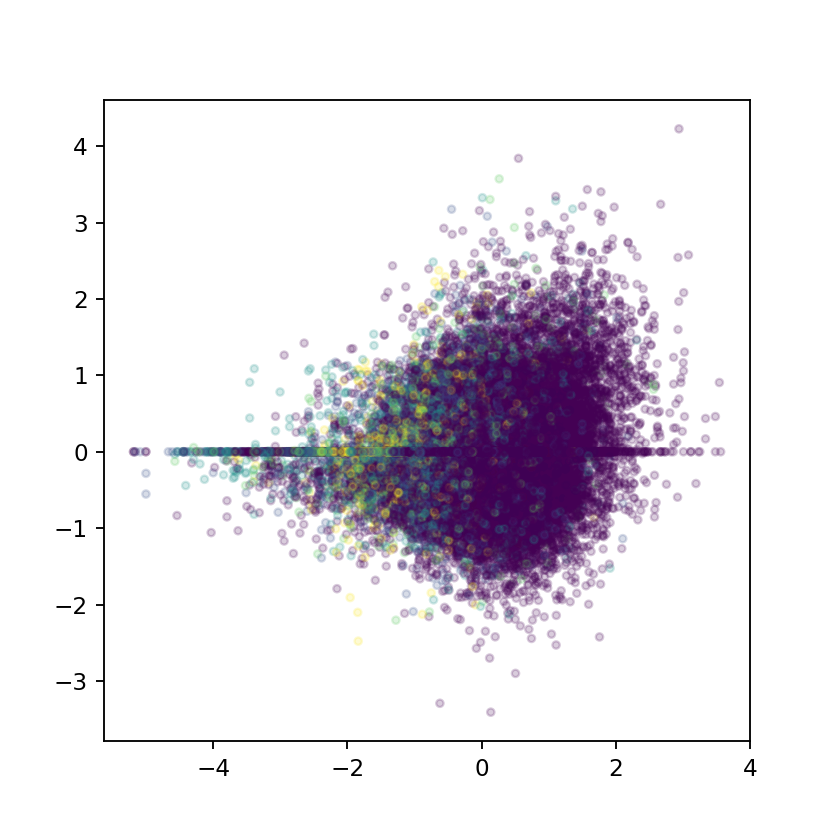

In [20]:
plt.figure(figsize=(5,5))
N = 50000
plt.scatter(realizations[0, :N], realizations[1, :N], c=realizations[2, :N], alpha=0.2, s = 10)
plt.show()

In [39]:
r = np.corrcoef(realizations)
values, vectors = np.linalg.eig(r)
sidxs = np.argsort(values)[::-1]
values = values[sidxs]
vectors = vectors[:,sidxs]
print(100 * values / np.sum(values)) 
print(vectors) 

[44.06199779 34.07216126 21.86584094]
[[ 0.71645555  0.07786966 -0.69327322]
 [ 0.18742166  0.9357331   0.29879203]
 [-0.67198554  0.34400563 -0.65581671]]


# Realigned Via PCA
The following plot shows the data rotated to align with its principle components, colored using the USDM label. To me, this result suggests that the data is linearly separable along a vector perpendicular to the 5 striped point )

<IPython.core.display.Javascript object>


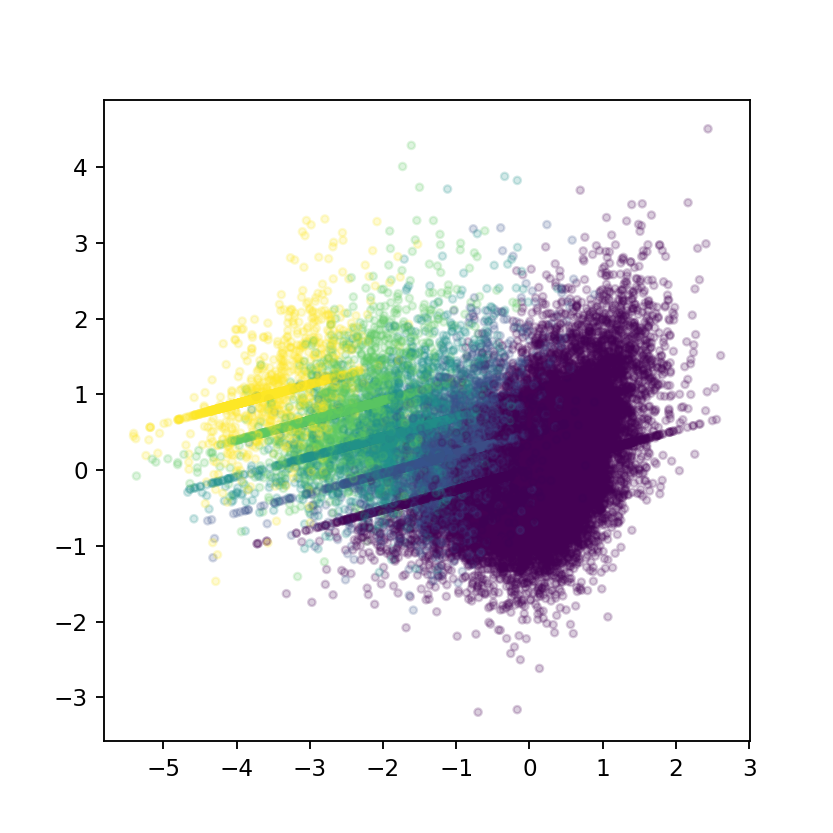

In [42]:
r_aligned = np.matmul(vectors, realizations)

plt.figure(figsize=(5,5))
plt.scatter(r_aligned[0, :N], r_aligned[1, :N], c=realizations[2, :N], alpha=0.2, s = 10)
plt.show()

#### Axis

In [ ]:
from IPython.display import Image
Image(filename='axis.PNG')